In [1]:
from thought_tracing import ThoughtTracing
from thought_prompt import *
from datasets import load_dataset
import os
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n = 100

dataset = load_dataset("Chuanyang-Jin/MMToM-QA")
dataset = dataset.map(lambda example, idx: {"id": idx}, with_indices=True)
dataset = dataset["train"].shuffle(seed=43).select(range(n))

In [3]:
avg_uncertainty = 0
n = 0
thresholder_scout = ThoughtTracing(
    parse_prompt=parse_prompt,
    hypothesis_prompt=hypothesis_prompt,
    rejuvenate_prompt=rejuvenate_prompt,
    summary_prompt=summary_prompt,
    CoT_prompt=CoT_prompt,
    conclusion_prompt=conclusion_prompt,
    mode='CoT',
    base_model="gpt-4o-mini",
    temperature=0.23,
    max_steps=10,
    N=5,
)

for i in tqdm(range(10)):
    raw = dataset[i]["question"].split("Question:")
    input = "".join(raw[:-1])
    question = raw[-1]
    answer = dataset[i]["answer"]
    acc, model_answer, reasoning, history, tokens = thresholder_scout.infer(input, question, answer)
    if acc == -1:
        continue
    elif acc == -2:
        print("Case", dataset[i]['id'], "parsing error")
        continue
    n += 1
    avg_uncertainty += thresholder_scout.avg_uncertainty

print("Average uncertainty:", avg_uncertainty / n)

100%|██████████| 10/10 [02:55<00:00, 17.51s/it]

Average uncertainty: 0.26437719538904947


In [3]:
overall_acc = []
overall_tokens = []
modes = ["Trace", "CoT", "Hybrid"]

for mode in modes:
    n = 0
    thought_tracing = ThoughtTracing(
        parse_prompt=parse_prompt,
        hypothesis_prompt=hypothesis_prompt,
        rejuvenate_prompt=rejuvenate_prompt,
        summary_prompt=summary_prompt,
        CoT_prompt=CoT_prompt,
        conclusion_prompt=conclusion_prompt,
        mode=mode,
        base_model="gpt-4o-mini",
        temperature=0.23,
        max_steps=12,
        uncertainty_threshold=0.3,
        N=5,
    )

    total_acc = 0
    total_tokens = (0, 0)

    os.makedirs(f"./{mode}_failed_cases", exist_ok=True)
    print(mode)
    for i in tqdm(range(len(dataset))):
        raw = dataset[i]["question"].split("Question:")
        input = "".join(raw[:-1])
        question = raw[-1]
        answer = dataset[i]["answer"]
        acc, model_answer, reasoning, history, tokens = thought_tracing.infer(input, question, answer)
        if acc == -1:
            continue
        elif acc == -2:
            print("Case", dataset[i]['id'], "parsing error")
            continue
        n += 1
        if not acc:
            with open(f"./{mode}_failed_cases/{dataset[i]['id']}.txt", "w") as f:
                f.write(f"Input: {dataset[i]['question']}\n")
                f.write(f"Answer: {answer}\n")
                f.write(f"Model Answer: {model_answer}\n")
                f.write(f"Model Reasoning: {reasoning}\n")
                f.write(f"History: {history}\n")
        total_acc += int(acc)
        total_tokens = (total_tokens[0] + tokens[0], total_tokens[1] + tokens[1])
    print(total_acc / n)
    print(n)
    print(total_tokens)
    overall_acc.append(total_acc / n)
    overall_tokens.append((total_tokens[0] / n, total_tokens[1] / n))

Trace


 36%|███▌      | 36/100 [24:04<42:15, 39.62s/it]  

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
index 5 is out of bounds for axis 0 with size 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Case 120 parsing error


 44%|████▍     | 44/100 [30:48<46:07, 49.42s/it]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
index 5 is out of bounds for axis 0 with size 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Case 564 parsing error


 73%|███████▎  | 73/100 [51:46<24:01, 53.38s/it]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
index 5 is out of bounds for axis 0 with size 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Case 21 parsing error


 77%|███████▋  | 77/100 [54:11<15:25, 40.24s/it]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
index 5 is out of bounds for axis 0 with size 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Case 299 parsing error


 83%|████████▎ | 83/100 [57:42<09:42, 34.27s/it]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
index 5 is out of bounds for axis 0 with size 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Case 541 parsing error


 92%|█████████▏| 92/100 [1:02:48<04:00, 30.10s/it]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
index 5 is out of bounds for axis 0 with size 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Case 538 parsing error


100%|██████████| 100/100 [1:09:00<00:00, 41.41s/it]


0.5526315789473685
76
(933677, 158632)
CoT


100%|██████████| 100/100 [37:49<00:00, 22.70s/it]


0.6585365853658537
82
(604608, 76592)
Hybrid


 83%|████████▎ | 83/100 [51:07<08:32, 30.13s/it]  

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
index 5 is out of bounds for axis 0 with size 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Case 541 parsing error


100%|██████████| 100/100 [1:01:23<00:00, 36.84s/it]

0.573170731707317
82
(981659, 139386)


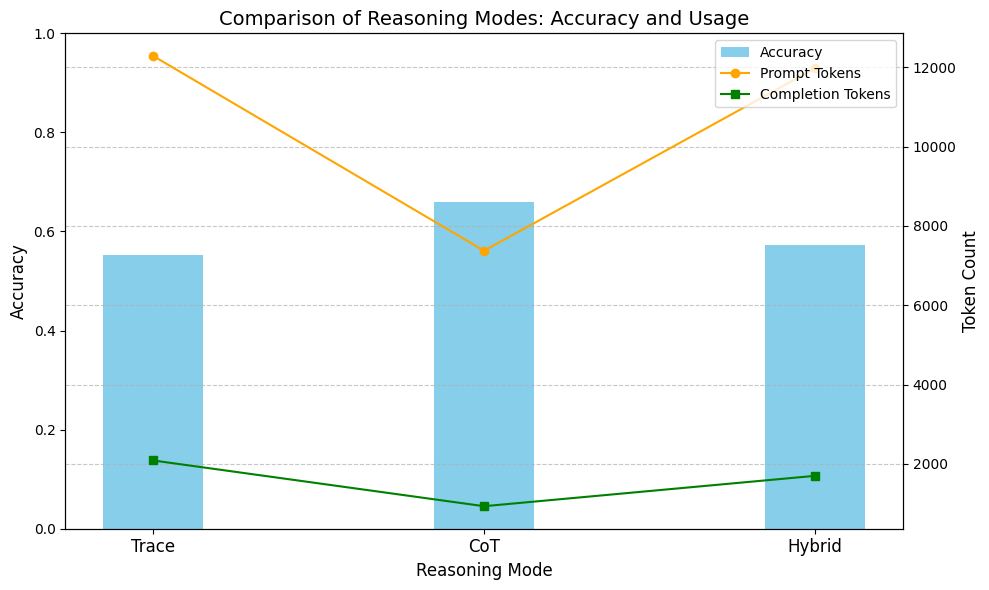

In [4]:
import matplotlib.pyplot as plt
import numpy as np

prompt_tokens = [i[0] for i in overall_tokens]
completion_tokens = [i[1] for i in overall_tokens]
x = np.arange(len(modes))
width = 0.3

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(x, overall_acc, width, label='Accuracy', color='skyblue')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xticks(x)
ax1.set_xticklabels(modes, fontsize=12)
ax1.set_xlabel('Reasoning Mode', fontsize=12)
ax1.set_title('Comparison of Reasoning Modes: Accuracy and Usage', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(x, prompt_tokens, marker='o', label='Prompt Tokens', color='orange')
ax2.plot(x, completion_tokens, marker='s', label='Completion Tokens', color='green')
ax2.set_ylabel('Token Count', fontsize=12)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()